# Workshop Attribute and Spatial Data Operations

## 1. Introduction

In this workshop, we will explore the concepts and techniques presented in: [Attribute Data Operations](https://py.geocompx.org/02-attribute-operations) and [Spatial Operations](https://py.geocompx.org/03-spatial-operations) from the book **"Geocomputation with Python"**. These sections cover basic operations for spatial analysis, combining vector, raster, and tabular (attribute) data.

The primary goal of this workshop is to become familiar with fundamental and advanced operations on spatial data (both raster and vector) and their associated attributes using **Python**. 

In this workshop you need to use data associated to your course project.

## 2. Required Data

To complete this workshop, each group must use the following type of datasets associated to your own course project:

### 2.1. Vector Data

Geospatial data in Shapefile format will be used, including administrative boundaries such as municipalities, as well as other relevant polygons like double drainages and land use coverages. Line data corresponding to roads will also be included.

### 2.2. Raster Data

### 2.3. Tabular Data

Tabular data with attributes for vector layers will be used, primarily consisting of inputs on conflict-affected population data associated with administrative boundaries.

## 5. Activities

### 5.1. Attribute Data Operations 

Filter entities based on specific attributes (e.g., select  dryland forests within the municipality of Puerto Gaitán that are close to roads).

Número de bosques en Puerto Gaitán cercanos a carreteras: 264


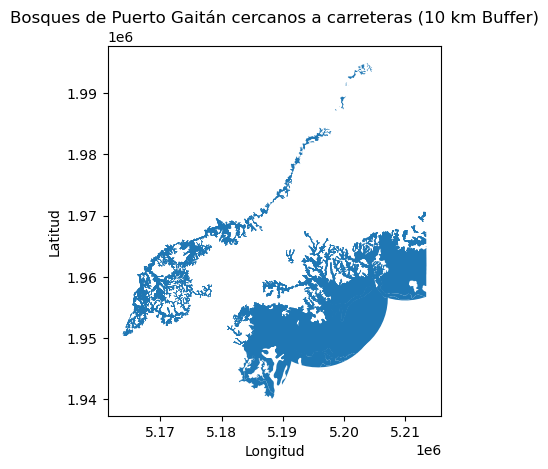

In [44]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Cargar las capas necesarias
carreteras = gpd.read_file("C:\\Users\\Andres Wilches\\Documents\\programacion-sig\\programacion_SIG\\Workshop_2_Attribute_and_Spatial_Data_Operations\\Data\\Via.shp")
coberturas = gpd.read_file("C:\\Users\\Andres Wilches\\Documents\\programacion-sig\\programacion_SIG\\Workshop_2_Attribute_and_Spatial_Data_Operations\\Data\\Coberturas.shp") 
municipios = gpd.read_file("C:\\Users\\Andres Wilches\\Documents\\programacion-sig\\programacion_SIG\\Workshop_2_Attribute_and_Spatial_Data_Operations\\Data\\Municipios.shp")

# Filtrar el municipio de Puerto Gaitán usando .loc() para aplicar condiciones
puerto_gaitan = municipios.loc[municipios["MpNombre"] == "Puerto Gaitan"]

# Filtrar las coberturas dentro del municipio de Puerto Gaitán
coberturas_pg = gpd.overlay(coberturas, puerto_gaitan, how="intersection", keep_geom_type=True)

# Crear un buffer de 10 km alrededor de las carreteras
carreteras_buffer = carreteras.buffer(10000)

# Convertir el buffer de carreteras a GeoDataFrame
carreteras_buffer_gdf = gpd.GeoDataFrame(geometry=carreteras_buffer, crs=carreteras.crs)

# Intersectar el buffer de las carreteras con las coberturas del municipio de Puerto Gaitán
coberturas_cercanas_carreteras = gpd.overlay(coberturas_pg, carreteras_buffer_gdf, how="intersection", keep_geom_type=True)

# Filtrar las coberturas que correspondan a bosques utilizando múltiples condiciones
bosques_pg_cercanos_carreteras = coberturas_cercanas_carreteras.loc[coberturas_cercanas_carreteras["nivel_3"] == "311"]

# Mostrar la salida de los resultados obtenidos
print(f"Número de bosques en Puerto Gaitán cercanos a carreteras: {len(bosques_pg_cercanos_carreteras)}")

# Visualizar el resultado en un gráfico (opcional)
bosques_pg_cercanos_carreteras.plot()
plt.title("Bosques de Puerto Gaitán cercanos a carreteras (10 km Buffer)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

Group data by a categorical attribute (e.g., land use type) and summarise other attributes like area or population.

In [47]:
import geopandas as gpd
import pandas as pd

# 1. Cargar las capas necesarias
coberturas = gpd.read_file("C:\\Users\\Andres Wilches\\Documents\\programacion-sig\\programacion_SIG\\Workshop_2_Attribute_and_Spatial_Data_Operations\\Data\\Coberturas.shp")
municipios = gpd.read_file("C:\\Users\\Andres Wilches\\Documents\\programacion-sig\\programacion_SIG\\Workshop_2_Attribute_and_Spatial_Data_Operations\\Data\\Municipios.shp") 
poblacion_victima = pd.read_csv("C:\\Users\\Andres Wilches\\Documents\\programacion-sig\\programacion_SIG\\Workshop_2_Attribute_and_Spatial_Data_Operations\\Data\\Víctimas_por_hecho_victimizante_por_año_Corte_DICIEMBRE_DE_2024.csv", sep=";")

# 2. Verificar y reproyectar las capas a un sistema proyectado adecuado
coberturas = coberturas.to_crs(epsg=9377)
municipios = municipios.to_crs(epsg=9377)

# 3. Intersección de las coberturas con los municipios
coberturas_municipios = gpd.overlay(coberturas, municipios, how="intersection", keep_geom_type=False)

# 4. Calcular el área en hectáreas para cada polígono resultante
coberturas_municipios["area_ha"] = coberturas_municipios.geometry.area / 10_000

# 5. Asegurarse de que las claves de unión sean del mismo tipo
coberturas_municipios["MpCodigo"] = coberturas_municipios["MpCodigo"].astype(str)
poblacion_victima["COD_CIUDAD_MUNI"] = poblacion_victima["COD_CIUDAD_MUNI"].astype(str)

# 6. Unir la tabla de población víctima del conflicto armado
coberturas_municipios = coberturas_municipios.merge(poblacion_victima, left_on="MpCodigo", right_on="COD_CIUDAD_MUNI", how="left")

# 7. Agrupar por tipo de uso de suelo y resumir atributos (población total y área promedio)
resumen = coberturas_municipios.groupby("MpNombre").agg(
    Poblacion_Victima=("EVENTOS", "sum"),
    Coberturas_Area=("nivel_3", lambda x: list(x.unique()))
).reset_index()

# 9. Mostrar el resumen de los resultados
print(resumen)

        MpNombre  Poblacion_Victima  \
0       Cumaribo              55404   
1      Mapiripan               3689   
2  Puerto Gaitan             295630   

                                     Coberturas_Area  
0  [321, 311, 323, 313, 314, 244, 511, 231, 242, ...  
1      [314, 244, 323, 313, 311, 231, 243, 242, 511]  
2  [314, 231, 311, 242, 511, 321, 243, 323, 313, ...  


Merge geometries and summarise data by a grouping attribute (e.g., dissolve administrative boundaries into regions).

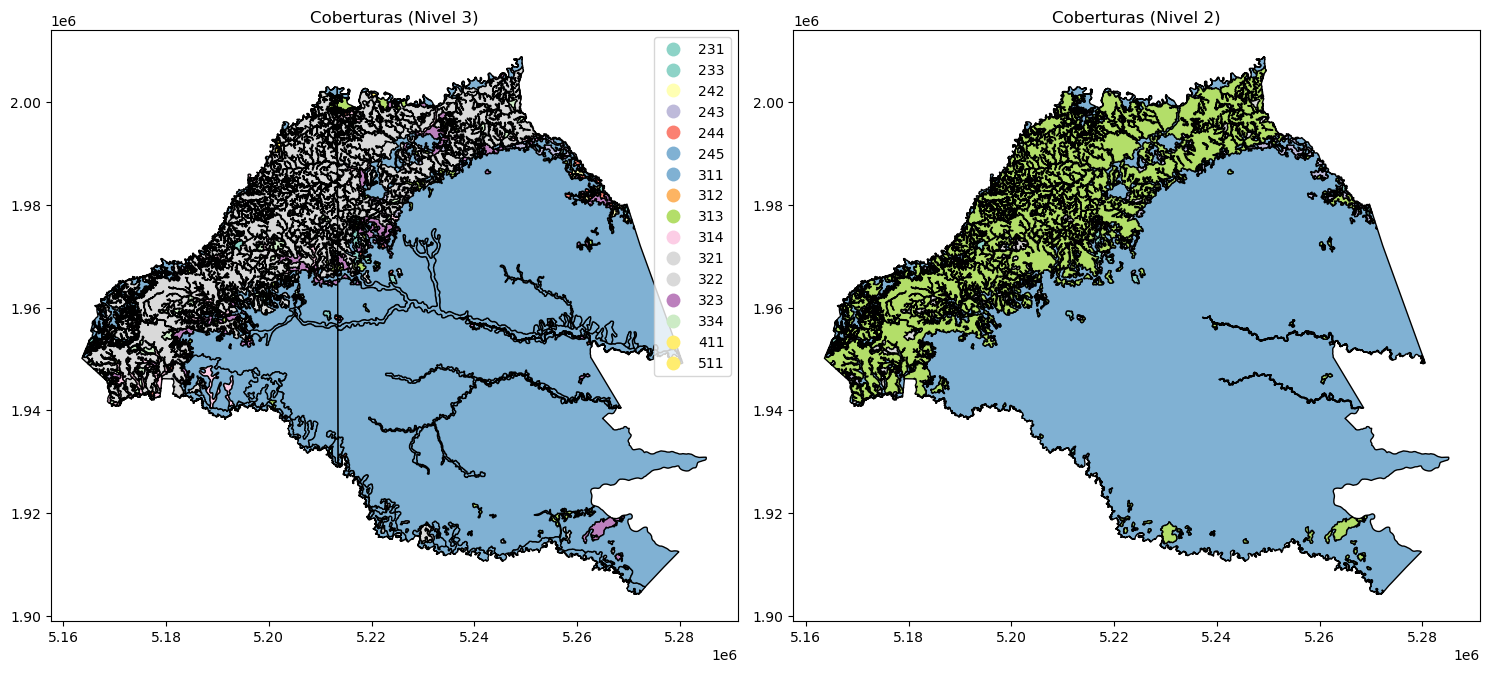

    nivel_3        area_ha
0       314       0.162519
1       244       0.157095
2       314       0.289259
3       323       0.039757
4       313       0.024794
..      ...            ...
823     311       2.534632
824     311  141456.659826
825     311      12.363593
826     321   36227.306869
827     511    1624.574551

[828 rows x 2 columns]
  nivel_2           area
0      23    2075.625801
1      24    7010.664477
2      31  511168.852511
3      32  146227.944176
4      33    4535.618994
5      41     170.382561
6      51    2117.361356


In [145]:
import geopandas as gpd
import pandas as pd

# 1. Cargar las capas necesarias
coberturas = gpd.read_file("C:\\Users\\Andres Wilches\\Documents\\programacion-sig\\programacion_SIG\\Workshop_2_Attribute_and_Spatial_Data_Operations\\Data\\Coberturas.shp")
municipios = gpd.read_file("\\Users\\Andres Wilches\\Documents\\programacion-sig\\programacion_SIG\\Workshop_2_Attribute_and_Spatial_Data_Operations\\Data\\Municipios.shp")

nivel_2 = coberturas.dissolve(by='nivel_2')

nivel_2['area'] = nivel_2.geometry.area/10_000

# 4. Restablecer el índice para acceder a la columna 'nivel_2' fácilmente
nivel_2 = nivel_2.reset_index()

# Crear una figura y un conjunto de subgráficos
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Mostrar la capa de municipios en el primer subgráfico
coberturas.plot(ax=ax[0], column='nivel_3', legend=True, cmap='Set3', edgecolor='black')
ax[0].set_title('Coberturas (Nivel 3)')

# Mostrar la capa disuelta por departamentos en el segundo subgráfico
nivel_2.plot(ax=ax[1], legend=True, cmap='Set3', edgecolor='black')
ax[1].set_title('Coberturas (Nivel 2)')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

print(coberturas[['nivel_3', 'area_ha']])
print(nivel_2[['nivel_2', 'area']])

### 5.2. Spatial Operations

#### 5.2.1. Spatial Relationships and Selection

Select entities based on their spatial relationship: e.g.  Identify urban areas within a conservation zone.

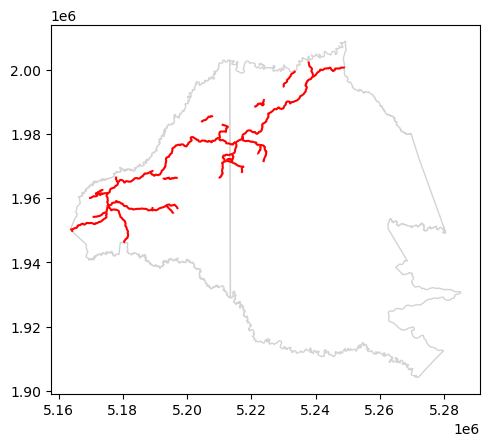

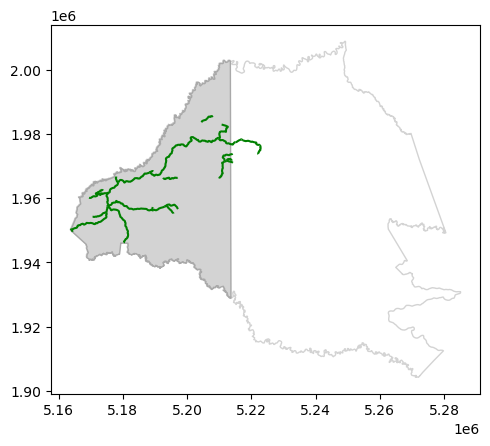

In [200]:
#Seleccionar vías que están en el municipio de Puerto Gaitán

carreteras = gpd.read_file("C:\\Users\\Andres Wilches\\Documents\\programacion-sig\\programacion_SIG\\Workshop_2_Attribute_and_Spatial_Data_Operations\\Data\\Via.shp")
municipios = gpd.read_file("C:\\Users\\Andres Wilches\\Documents\\programacion-sig\\programacion_SIG\\Workshop_2_Attribute_and_Spatial_Data_Operations\\Data\\Municipios.shp")

Puerto_Gaitan = municipios[municipios['MpNombre'] == 'Puerto Gaitan']
Puerto_Gaitan

sel = carreteras.intersects(Puerto_Gaitan.geometry.iloc[0])
sel

pg_vias = carreteras[sel]
pg_vias

# Original
base = municipios.plot(color='white', edgecolor='lightgrey')
carreteras.plot(ax=base, color='red');
# Subset (intersects)
base = municipios.plot(color='white', edgecolor='lightgrey')
Puerto_Gaitan.plot(ax=base, color='lightgrey', edgecolor='darkgrey')
pg_vias.plot(ax=base, color='green');

Identify entities that intersect with another layer. e.g. Rivers intersecting with hazard zones.

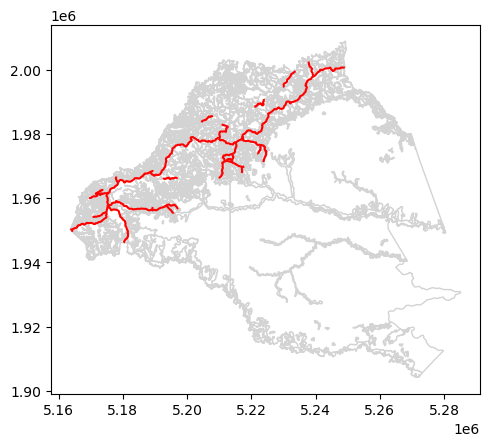

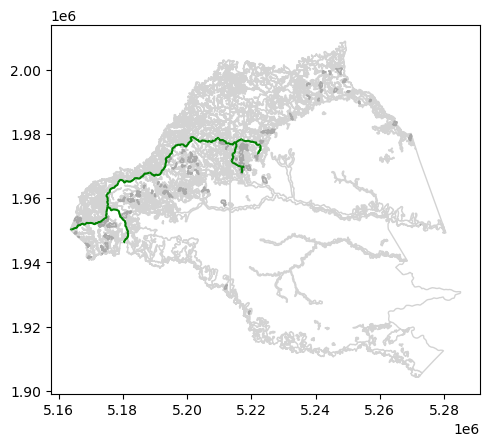

In [212]:
#Se identifican áreas de pastos y áreas abiertas que se intersectan con las vías

coberturas = gpd.read_file("C:\\Users\\Andres Wilches\\Documents\\programacion-sig\\programacion_SIG\\Workshop_2_Attribute_and_Spatial_Data_Operations\\Data\\Coberturas.shp")
carreteras = gpd.read_file("C:\\Users\\Andres Wilches\\Documents\\programacion-sig\\programacion_SIG\\Workshop_2_Attribute_and_Spatial_Data_Operations\\Data\\Via.shp")

pastos_y_areasabiertas = coberturas[coberturas['nivel_2'].isin(['23', '33'])]
sel = carreteras.intersects(pastos_y_areasabiertas.union_all())
vias_p_a = carreteras[sel]
vias_p_a

# Original
base = coberturas.plot(color='white', edgecolor='lightgrey')
carreteras.plot(ax=base, color='red');
# Subset by intersection with two polygons
base = coberturas.plot(color='white', edgecolor='lightgrey')
pastos_y_areasabiertas.plot(ax=base, color='lightgrey', edgecolor='darkgrey')
vias_p_a.plot(ax=base, color='green');

#### 5.2.2. Areas of influence

Create influence zones (buffer) around points or lines, such as rivers or roads.

<Axes: >

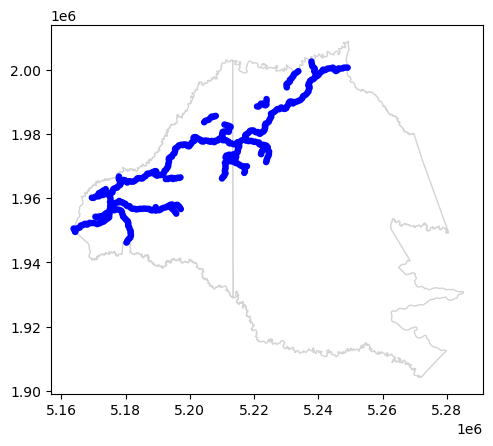

In [275]:
#Se crea un buffer de 1000 m sobre las vías

municipios = gpd.read_file("C:\\Users\\Andres Wilches\\Documents\\programacion-sig\\programacion_SIG\\Workshop_2_Attribute_and_Spatial_Data_Operations\\Data\\Municipios.shp")

crs = 9377
vias_buffer = carreteras.copy().to_crs(crs)
vias_buffer.geometry = vias_buffer.buffer(1000)
vias_buffer

base = municipios.plot(color='white', edgecolor='lightgrey')
vias_buffer.plot(ax=base, color='blue')

Use the buffer to identify affected areas. e.g. Determine agricultural areas impacted by road buffers.

<Axes: >

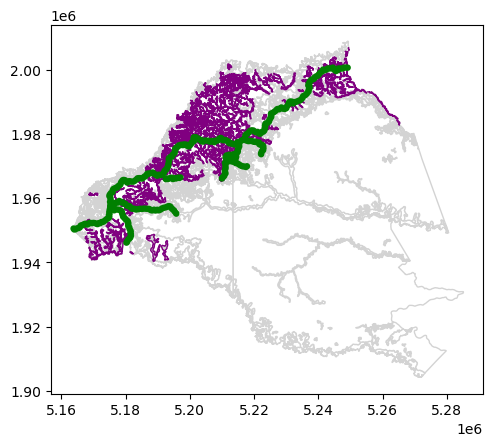

In [307]:
#Se usa el buffer para determinar áreas de bosque de galería que son impactados por los buffer de vías.

coberturas = gpd.read_file("C:\\Users\\Andres Wilches\\Documents\\programacion-sig\\programacion_SIG\\Workshop_2_Attribute_and_Spatial_Data_Operations\\Data\\Coberturas.shp")

bosques_galeria = coberturas[coberturas['nivel_3'].isin(['314'])]
sel = vias_buffer.intersects(bosques_galeria.union_all())
vias_buffer = vias_buffer[sel]
vias_buffer

base = coberturas.plot(color='white', edgecolor='lightgrey')
bosques_galeria.plot(ax=base, color='lightgrey', edgecolor='purple')
vias_buffer.plot(ax=base, color='green')

#### 5.2.3. Overlay operations

Combine two vector layers (e.g., conservation areas and hazard zones) to generate a new layer with the intersection. 

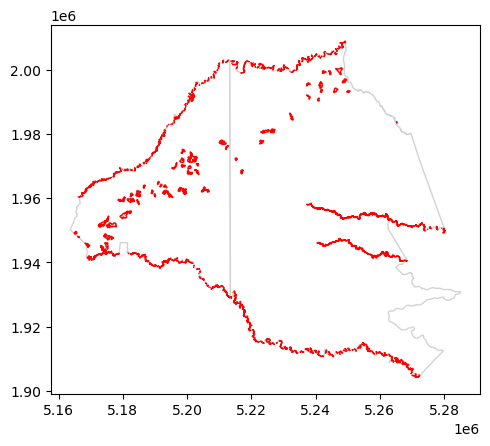

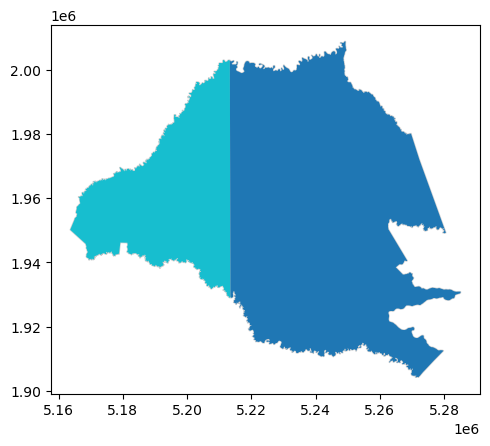

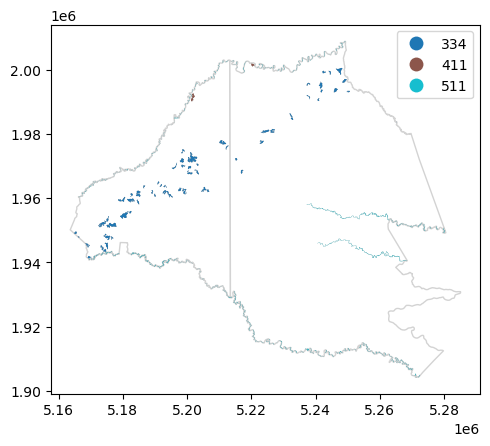

In [347]:
##Se combina la capa de coberturas específicas y de municipios para generar la insertersección.

coberturas = gpd.read_file("C:\\Users\\Andres Wilches\\Documents\\programacion-sig\\programacion_SIG\\Workshop_2_Attribute_and_Spatial_Data_Operations\\Data\\Coberturas.shp")
municipios = gpd.read_file("C:\\Users\\Andres Wilches\\Documents\\programacion-sig\\programacion_SIG\\Workshop_2_Attribute_and_Spatial_Data_Operations\\Data\\Municipios.shp")

zonas_pantanosas = coberturas[coberturas['nivel_3'].isin(['411','511','334'])]

municipios_x_coberturas = municipios[municipios.intersects(zonas_pantanosas.union_all())]
municipios_x_coberturas

mxc_join = zonas_pantanosas.sjoin(municipios, how='left')
mxc_join

# Random points
base = municipios.plot(color='white', edgecolor='lightgrey')
zonas_pantanosas.plot(ax=base, color='None', edgecolor='red');
# World countries intersecting with the points
base = municipios.plot(color='white', edgecolor='lightgrey')
municipios_x_coberturas.plot(ax=base, column='MpNombre');
# Points with joined country names
base = municipios.plot(color='white', edgecolor='lightgrey')
mxc_join.geometry.plot(ax=base, color='grey')
mxc_join.plot(ax=base, column='nivel_3', legend=True);

Identify parts of a layer not overlapping with another. e.g.Conservation zones outside urban areas.

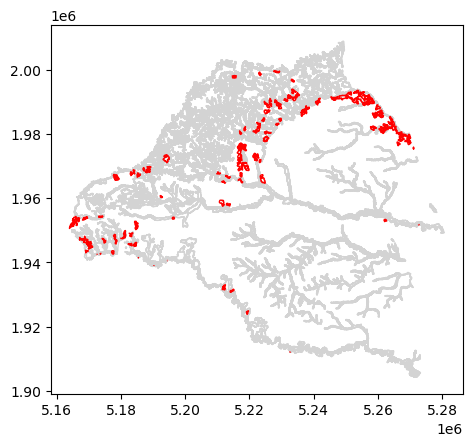

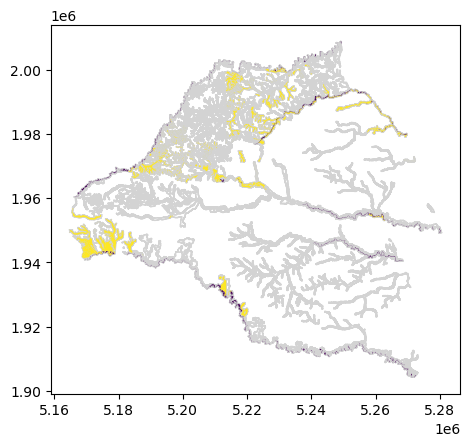

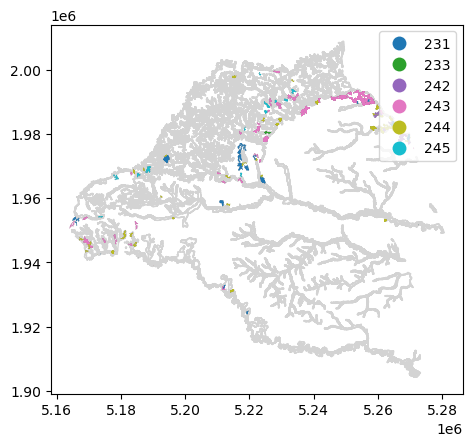

In [366]:
#Identificar humedales en coberturas transformadas, como indicio de humedales transformados o afectados.

coberturas = gpd.read_file("C:\\Users\\Andres Wilches\\Documents\\programacion-sig\\programacion_SIG\\Workshop_2_Attribute_and_Spatial_Data_Operations\\Data\\Coberturas.shp")
humedales = gpd.read_file("C:\\Users\\Andres Wilches\\Documents\\programacion-sig\\programacion_SIG\\Workshop_2_Attribute_and_Spatial_Data_Operations\\Data\\Humedales.shp")

coberturas_transformadas = coberturas[coberturas['nivel_1'].isin(['2'])]

humedales_x_coberturas = humedales[humedales.intersects(coberturas_transformadas.union_all())]
humedales_x_coberturas

hxc_join = coberturas_transformadas.sjoin(humedales, how='left')
hxc_join

# Random points
base = humedales.plot(color='white', edgecolor='lightgrey')
coberturas_transformadas.plot(ax=base, color='None', edgecolor='red');
# World countries intersecting with the points
base = humedales.plot(color='white', edgecolor='lightgrey')
humedales_x_coberturas.plot(ax=base, column='Nivel_Hume');
# Points with joined country names
base = humedales.plot(color='white', edgecolor='lightgrey')
hxc_join.geometry.plot(ax=base, color='grey')
hxc_join.plot(ax=base, column='nivel_3', legend=True);